# **Preparação dos dados**

In [1]:
!pip install pyopenms

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.8/59.8 MB 11.0 MB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount('/content/drive')

MessageError: Error: credential propagation was unsuccessful

In [ ]:
import pyopenms as po
import os

caminho_do_arquivo = '/content/drive/MyDrive/Trabalho_RNAP/dados_mzML/PG_1.mzML'


if not os.path.exists(caminho_do_arquivo):
    print(f"ERRO: Arquivo não encontrado em: {caminho_do_arquivo}")
    print("Verifique se o caminho está correto e se o Google Drive está montado.")
else:
    print("Arquivo encontrado! Lendo...")

    # Carrega o experimento
    exp = po.MSExperiment()
    po.MzMLFile().load(caminho_do_arquivo, exp)

    # Verifica quantos cromatogramas estão no arquivo
    chroms = exp.getChromatograms()
    print(f"\nO arquivo contém {len(chroms)} cromatogramas (transições).")

    print("\n--- Lista de Cromatogramas (Transições) Encontrados ---")
    for i, chrom in enumerate(chroms):
        # O 'getNativeID()' geralmente nos diz o que é a transição
        print(f"  ID {i}: {chrom.getNativeID()} | Número de pontos: {len(chrom.get_peaks()[0])}")

Arquivo encontrado! Lendo...

O arquivo contém 6 cromatogramas (transições).

--- Lista de Cromatogramas (Transições) Encontrados ---
  ID 0: TIC | Número de pontos: 1174
  ID 1: SRM SIC 363.035,121.19 | Número de pontos: 587
  ID 2: SRM SIC 363.035,327.13 | Número de pontos: 587
  ID 3: SRM SIC 366.1,124.09 | Número de pontos: 587
  ID 4: SRM SIC 366.1,330.1 | Número de pontos: 587
  ID 5: Pump Pressure 1 | Número de pontos: 480


In [ ]:
!pip install pyopenms openpyxl

import os
import pyopenms as po
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.model_selection import train_test_split


path_mzml_folder = '/content/drive/MyDrive/Trabalho_RNAP/dados_mzML/'

path_master_sheet = '/content/drive/MyDrive/Trabalho_RNAP/labels.xlsx'

path_output_folder = '/content/drive/MyDrive/Trabalho_RNAP/dados_finais_corrigidos/'


indices_para_extrair = [1, 2, 3, 4] # Os 4 canais SRM
comprimento_alvo = 587             # Nosso comprimento com padding

# Configurações da Divisão
test_size = 0.3  # 30% para (val + teste)
val_size = 0.5   # 50% de 30% = 15% para val, 15% para teste
random_state = 42 # Para reprodutibilidade

# ----------------------------------------------------------------

print("Iniciando POP 1.0 (Versão Final): Processamento e Alinhamento...")

os.makedirs(path_output_folder, exist_ok=True)

try:
    print(f"Carregando planilha-mestra: {path_master_sheet}")
    df_mestres = pd.read_excel(path_master_sheet, dtype={
        'NomeArquivo': str,
        'AmostraMae': str
    })

    df_mestres['RazaoArea'] = df_mestres['RazaoArea'].astype(str).str.replace(',', '.').astype(float)
    df_mestres['ConcMedia'] = df_mestres['ConcMedia'].astype(str).str.replace(',', '.').astype(float)

    # Cria um dicionário (lookup map) para os rótulos
    # Ex: {'PG_1.mzML': ('PG_1', 7.909, 19.911), ...}
    label_map = {}
    for index, row in df_mestres.iterrows():
        label_map[row['NomeArquivo']] = (
            row['AmostraMae'],
            row['RazaoArea'],
            row['ConcMedia']
        )
    print(f"Encontrados {len(label_map)} rótulos únicos na planilha-mestra.")

except FileNotFoundError:
    print(f"ERRO CRÍTICO: Planilha-mestra não encontrada em {path_master_sheet}")
    print("Por favor, verifique o nome e o caminho do arquivo.")
    raise

print(f"Iniciando varredura e processamento dos arquivos em {path_mzml_folder}...")

# Listas para guardar nossos dados perfeitamente alinhados
lista_X_sinal = []
lista_Y_razao = []
lista_Y_conc = []
lista_amostra_mae = []

todos_os_arquivos_mzml = [f for f in os.listdir(path_mzml_folder) if f.endswith('.mzML')]

for nome_arquivo in tqdm(todos_os_arquivos_mzml, desc="Processando arquivos .mzML"):

    if nome_arquivo in label_map:

        amostra_mae, razao_area, conc_ind = label_map[nome_arquivo]

        caminho_completo = os.path.join(path_mzml_folder, nome_arquivo)
        matriz_da_amostra = np.zeros((comprimento_alvo, len(indices_para_extrair)))
        dados_encontrados = True

        try:
            exp = po.MSExperiment()
            po.MzMLFile().load(caminho_completo, exp)
            chroms = exp.getChromatograms()

            for i, idx in enumerate(indices_para_extrair):
                chrom = chroms[idx]
                intensidades = chrom.get_peaks()[1]
                tamanho_atual = len(intensidades)

                if tamanho_atual <= comprimento_alvo:
                    matriz_da_amostra[0:tamanho_atual, i] = intensidades
                else:
                    matriz_da_amostra[:, i] = intensidades[0:comprimento_alvo]

        except Exception as e:
            print(f"\nAviso: Erro ao processar o arquivo {nome_arquivo}: {e}. Pulando.")
            dados_encontrados = False

        if dados_encontrados:
            lista_X_sinal.append(matriz_da_amostra)
            lista_Y_razao.append(razao_area)
            lista_Y_conc.append(conc_ind)
            lista_amostra_mae.append(amostra_mae)

    else:
        # Arquivo não está na planilha-mestra (ex: 'branco.mzML', 'CT_9.mzML')
        # print(f"Info: Arquivo {nome_arquivo} não encontrado na planilha-mestra. Ignorando.")
        pass

print(f"\nProcessamento concluído. {len(lista_X_sinal)} amostras válidas foram processadas e alinhadas.")

X_final = np.stack(lista_X_sinal, axis=0)
y_razao_final = np.array(lista_Y_razao)
y_conc_final = np.array(lista_Y_conc)
amostras_mae_final = np.array(lista_amostra_mae)

print(f"Shape final dos dados X (Sinais): {X_final.shape}")

print("Iniciando divisão segura (baseada nas amostras-mãe)...")

# Pega a lista de IDs únicos de amostras-mãe
unique_amostras = np.unique(amostras_mae_final)
print(f"Encontradas {len(unique_amostras)} amostras-mãe únicas para a divisão.")

# 1. Divide os IDs únicos
train_ids, val_test_ids = train_test_split(
    unique_amostras,
    test_size=test_size,
    random_state=random_state
)

# 2. Divide os (validação + teste) em validação e teste
val_ids, test_ids = train_test_split(
    val_test_ids,
    test_size=val_size,
    random_state=random_state
)

print(f"Divisão de IDs: {len(train_ids)} (treino), {len(val_ids)} (validação), {len(test_ids)} (teste).")

# 3. Cria máscaras booleanas para selecionar os dados
# Isso garante que todas as duplicatas (ex: PG_1 e PG_1_1) fiquem juntas
train_mask = np.isin(amostras_mae_final, train_ids)
val_mask = np.isin(amostras_mae_final, val_ids)
test_mask = np.isin(amostras_mae_final, test_ids)

print(f"Salvando 9 arquivos de dados finais em: {path_output_folder}")

# --- ARQUIVOS X (Sinais Brutos) ---
np.save(os.path.join(path_output_folder, 'X_train.npy'), X_final[train_mask])
np.save(os.path.join(path_output_folder, 'X_val.npy'), X_final[val_mask])
np.save(os.path.join(path_output_folder, 'X_test.npy'), X_final[test_mask])

# --- ARQUIVOS Y para Experimento A (Prever Razão) ---
np.save(os.path.join(path_output_folder, 'y_train_razao.npy'), y_razao_final[train_mask])
np.save(os.path.join(path_output_folder, 'y_val_razao.npy'), y_razao_final[val_mask])
np.save(os.path.join(path_output_folder, 'y_test_razao.npy'), y_razao_final[test_mask])

# --- ARQUIVOS Y para Experimento B (Prever Concentração Individual) ---
np.save(os.path.join(path_output_folder, 'y_train_conc.npy'), y_conc_final[train_mask])
np.save(os.path.join(path_output_folder, 'y_val_conc.npy'), y_conc_final[val_mask])
np.save(os.path.join(path_output_folder, 'y_test_conc.npy'), y_conc_final[test_mask])

print("\n--- SUCESSO! PREPARAÇÃO DE DADOS CORRIGIDA E CONCLUÍDA! ---")
print("Temos 9 arquivos prontos para os novos experimentos.")
print(f"Shapes (Treino): X={X_final[train_mask].shape}, y_razao={y_razao_final[train_mask].shape}, y_conc={y_conc_final[train_mask].shape}")
print(f"Shapes (Val):    X={X_final[val_mask].shape}, y_razao={y_razao_final[val_mask].shape}, y_conc={y_conc_final[val_mask].shape}")
print(f"Shapes (Teste):  X={X_final[test_mask].shape}, y_razao={y_razao_final[test_mask].shape}, y_conc={y_conc_final[test_mask].shape}")

Iniciando POP 1.0 (Versão Final): Processamento e Alinhamento...
Carregando planilha-mestra: /content/drive/MyDrive/Trabalho_RNAP/labels.xlsx
Encontrados 116 rótulos únicos na planilha-mestra.
Iniciando varredura e processamento dos arquivos em /content/drive/MyDrive/Trabalho_RNAP/dados_mzML/...


Processando arquivos .mzML: 100%|██████████| 115/115 [00:02<00:00, 41.95it/s]



Processamento concluído. 113 amostras válidas foram processadas e alinhadas.
Shape final dos dados X (Sinais): (113, 587, 4)
Iniciando divisão segura (baseada nas amostras-mãe)...
Encontradas 58 amostras-mãe únicas para a divisão.
Divisão de IDs: 40 (treino), 9 (validação), 9 (teste).
Salvando 9 arquivos de dados finais em: /content/drive/MyDrive/Trabalho_RNAP/dados_finais_corrigidos/

--- SUCESSO! PREPARAÇÃO DE DADOS CORRIGIDA E CONCLUÍDA! ---
Temos 9 arquivos prontos para os novos experimentos.
Shapes (Treino): X=(78, 587, 4), y_razao=(78,), y_conc=(78,)
Shapes (Val):    X=(18, 587, 4), y_razao=(18,), y_conc=(18,)
Shapes (Teste):  X=(17, 587, 4), y_razao=(17,), y_conc=(17,)


# **Modelo baseline**

Obs: Acho que está certo, me dêem feedback - HS

Iniciando Experimento A: Baseline Analítico (Regressão Linear na Razão de Áreas)
Carregando rótulos (Y) de treino e teste...
Dados carregados. 78 amostras de treino, 17 de teste.
Treinando o modelo de Regressão Linear...
Modelo treinado. Equação: Conc = (2.8058 * Razao) + -2.2807

--- AVALIAÇÃO DO MODELO BASELINE (Analítico Corrigido) ---
Conjunto de Teste (n=17):
  R² (Coef. de Determinação): 1.0000
  MSE (Erro Quadrático Médio): 0.0000
  MAE (Erro Absoluto Médio):  0.0000


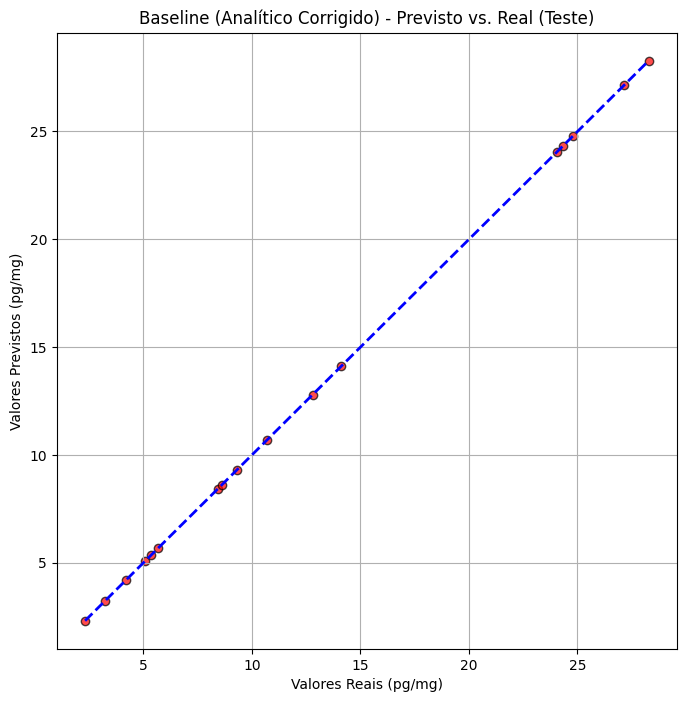

In [ ]:
import numpy as np
import os
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

caminho_dados_corrigidos = '/content/drive/MyDrive/Trabalho_RNAP/dados_finais_corrigidos/'

print("Iniciando Experimento A: Baseline Analítico (Regressão Linear na Razão de Áreas)")

# Para este baseline, não precisamos dos dados de sinal (X_train.npy)
print("Carregando rótulos (Y) de treino e teste...")
try:
    # --- DADOS DE TREINO ---
    # Entrada (X) do nosso baseline: A Razão de Áreas
    # Rótulo (y) do nosso baseline: A Concentração
    X_baseline_train = np.load(os.path.join(caminho_dados_corrigidos, 'y_train_razao.npy'))
    y_baseline_train = np.load(os.path.join(caminho_dados_corrigidos, 'y_train_conc.npy'))

    # --- DADOS DE TESTE ---
    X_baseline_test = np.load(os.path.join(caminho_dados_corrigidos, 'y_test_razao.npy'))
    y_baseline_test = np.load(os.path.join(caminho_dados_corrigidos, 'y_test_conc.npy'))

except FileNotFoundError as e:
    print(f"ERRO: Arquivo não encontrado! {e}")
    print("Execute novamente o script de preparação de dados (POP 1.0).")
    raise

print(f"Dados carregados. {len(X_baseline_train)} amostras de treino, {len(X_baseline_test)} de teste.")

# O Scikit-learn espera que a entrada (X) seja uma matriz 2D.
# Nossos dados (ex: 78,) precisam ser (78, 1).
X_baseline_train = X_baseline_train.reshape(-1, 1)
X_baseline_test = X_baseline_test.reshape(-1, 1)

print("Treinando o modelo de Regressão Linear...")
linear_model = LinearRegression()
linear_model.fit(X_baseline_train, y_baseline_train)

# Imprime a equação da reta que o modelo aprendeu
slope = linear_model.coef_[0]
intercept = linear_model.intercept_
print(f"Modelo treinado. Equação: Conc = ({slope:.4f} * Razao) + {intercept:.4f}")

print("\n--- AVALIAÇÃO DO MODELO BASELINE (Analítico Corrigido) ---")

# Faz as previsões no conjunto de teste
y_pred = linear_model.predict(X_baseline_test)

# Calcular métricas
mse_test = mean_squared_error(y_baseline_test, y_pred)
mae_test = mean_absolute_error(y_baseline_test, y_pred)
r2_test = r2_score(y_baseline_test, y_pred)

print(f"Conjunto de Teste (n={len(y_baseline_test)}):")
print(f"  R² (Coef. de Determinação): {r2_test:.4f}")
print(f"  MSE (Erro Quadrático Médio): {mse_test:.4f}")
print(f"  MAE (Erro Absoluto Médio):  {mae_test:.4f}")

plt.figure(figsize=(8, 8))
plt.scatter(y_baseline_test, y_pred, alpha=0.7, edgecolors='k', color='red')
plt.plot([min(y_baseline_test), max(y_baseline_test)], [min(y_baseline_test), max(y_baseline_test)], '--', color='blue', lw=2)
plt.xlabel("Valores Reais (pg/mg)")
plt.ylabel("Valores Previstos (pg/mg)")
plt.title("Baseline (Analítico Corrigido) - Previsto vs. Real (Teste)")
plt.grid(True)
plt.show()

# **Modelo intermediário (1D - CNN)**

Obs: Ainda estou pensando sobre esse - HS

Iniciando Experimento B: Modelo Deep Learning (1D-CNN End-to-End Corrigido)
Carregando dados de SINAL (X) e CONCENTRAÇÃO (y_conc)...
Dados carregados. Shape X_train: (78, 587, 4)
Shape X_val:   (18, 587, 4)
Shape X_test:  (17, 587, 4)


Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)      │ (None, 587, 4)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_14 (Conv1D)              │ (None, 587, 16)        │           464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_14 (MaxPooling1D) │ (None, 293, 16)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_15 (Conv1D)              │ (None, 293, 32)        │         2,592 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_15 (MaxPooling1D) │ (None, 146, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_7      │ (None, 32)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,145 (16.19 KB)

 Trainable params: 4,145 (16.19 KB)

 Non-trainable params: 0 (0.00 B)


Iniciando o treinamento da 1D-CNN (Corrigida)...
Epoch 1/150
5/5 - 2s - 431ms/step - loss: 685687.8125 - mae: 622.8267 - val_loss: 6957.5723 - val_mae: 80.0062
Epoch 2/150
5/5 - 0s - 32ms/step - loss: 238712.8750 - mae: 363.0329 - val_loss: 38449.8594 - val_mae: 193.0580
Epoch 3/150
5/5 - 0s - 30ms/step - loss: 121505.7188 - mae: 281.9030 - val_loss: 4921.7051 - val_mae: 58.2654
Epoch 4/150
5/5 - 0s - 30ms/step - loss: 78079.8984 - mae: 193.4488 - val_loss: 19041.3984 - val_mae: 130.8782
Epoch 5/150
5/5 - 0s - 31ms/step - loss: 60252.5078 - mae: 190.0993 - val_loss: 805.5602 - val_mae: 25.8140
Epoch 6/150
5/5 - 0s - 30ms/step - loss: 41202.9570 - mae: 163.8217 - val_loss: 7125.6572 - val_mae: 81.7868
Epoch 7/150
5/5 - 0s - 29ms/step - loss: 34565.5977 - mae: 144.1903 - val_loss: 4342.5737 - val_mae: 60.0985
Epoch 8/150
5/5 - 0s - 36ms/step - loss: 11735.4131 - mae: 84.4422 - val_loss: 875.6820 - val_mae: 26.4690
Epoch 9/150
5/5 - 0s - 29ms/step - loss: 6014.2114 - mae: 58.6484 - val_l

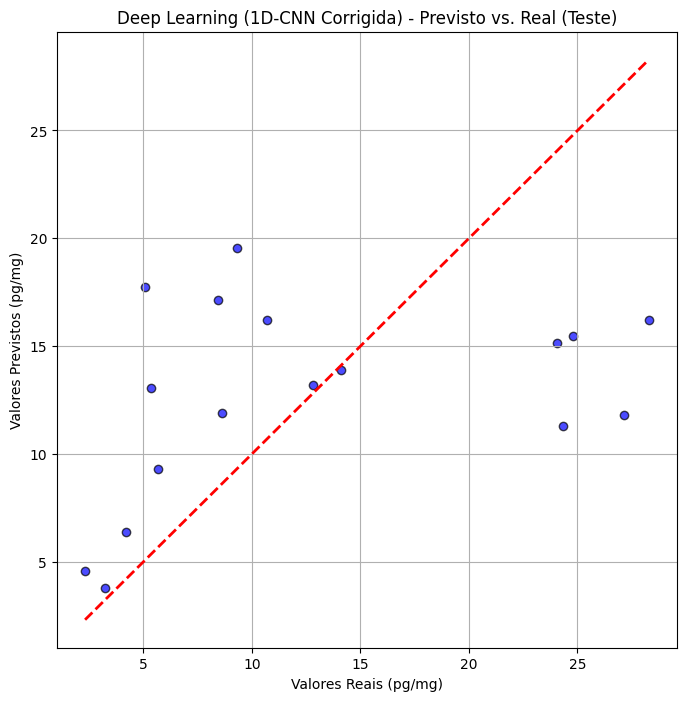

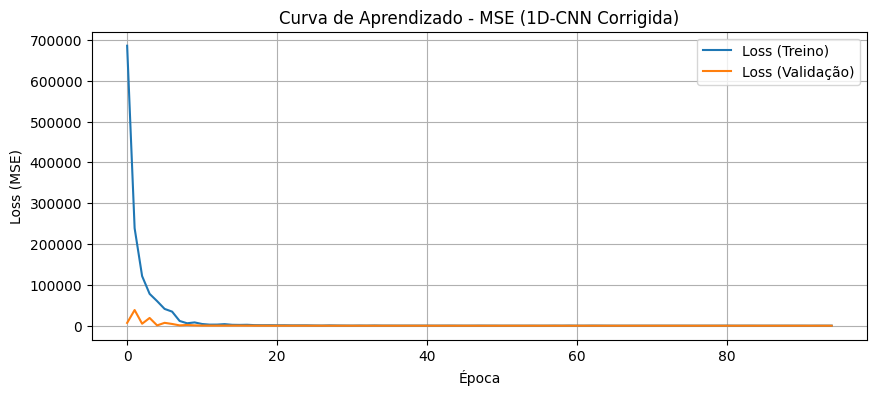

In [ ]:
import numpy as np
import os
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, GlobalAveragePooling1D, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

# --- 1. CONFIGURAÇÃO ---
# Caminho para a pasta com os 9 arquivos corrigidos
caminho_dados_corrigidos = '/content/drive/MyDrive/Trabalho_RNAP/dados_finais_corrigidos/'

print("Iniciando Experimento B: Modelo Deep Learning (1D-CNN End-to-End Corrigido)")

# --- 2. Carregar os Dados CORRIGIDOS ---
print("Carregando dados de SINAL (X) e CONCENTRAÇÃO (y_conc)...")
try:
    X_train = np.load(os.path.join(caminho_dados_corrigidos, 'X_train.npy'))
    y_train = np.load(os.path.join(caminho_dados_corrigidos, 'y_train_conc.npy'))

    X_val = np.load(os.path.join(caminho_dados_corrigidos, 'X_val.npy'))
    y_val = np.load(os.path.join(caminho_dados_corrigidos, 'y_val_conc.npy'))

    X_test = np.load(os.path.join(caminho_dados_corrigidos, 'X_test.npy'))
    y_test = np.load(os.path.join(caminho_dados_corrigidos, 'y_test_conc.npy'))

except FileNotFoundError as e:
    print(f"ERRO: Arquivo não encontrado! {e}")
    print("Execute novamente o script de preparação de dados (POP 1.0).")
    raise

print(f"Dados carregados. Shape X_train: {X_train.shape}") # Deve ser (78, 587, 4)
print(f"Shape X_val:   {X_val.shape}") # Deve ser (18, 587, 4)
print(f"Shape X_test:  {X_test.shape}") # Deve ser (17, 587, 4)
# --- Construção do Modelo 1D-CNN ---

# Define o fator de regularização L2 (Weight Decay)
# Este é o hiperparâmetro que combate o overfitting. 0.001 é um bom começo.
l2_factor = 0.001

# Define o formato de entrada
input_shape = (X_train.shape[1], X_train.shape[2]) # (587, 4)

# Camada de Entrada
inputs = Input(shape=input_shape)

# Bloco 1
x = Conv1D(filters=16, kernel_size=7, activation='relu', padding='same',
           kernel_regularizer=l2(l2_factor))(inputs)
x = MaxPooling1D(pool_size=2)(x)

# Bloco 2
x = Conv1D(filters=32, kernel_size=5, activation='relu', padding='same',
           kernel_regularizer=l2(l2_factor))(x)
x = MaxPooling1D(pool_size=2)(x)

# Camada de Pooling Global
x = GlobalAveragePooling1D()(x)

# Camadas Densas
x = Dense(32, activation='relu', kernel_regularizer=l2(l2_factor))(x)
x = Dropout(0.4)(x) # Aumentamos o dropout para 0.4

# Camada de Saída (1 neurônio para regressão)
outputs = Dense(1)(x)

# Cria o modelo
cnn_model_corrigido = Model(inputs=inputs, outputs=outputs)

# Compila o modelo
cnn_model_corrigido.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='mean_squared_error',
    metrics=['mae']
)

# Mostra um resumo da arquitetura
cnn_model_corrigido.summary()

early_stopper = EarlyStopping(
    monitor='val_loss', # Foca no erro de validação
    patience=20,        # Aumentamos um pouco a paciência
    verbose=1,
    restore_best_weights=True # Salva o melhor modelo
)

print("\nIniciando o treinamento da 1D-CNN (Corrigida)...")
history = cnn_model_corrigido.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=150, # Máximo de épocas
    batch_size=16,
    callbacks=[early_stopper],
    verbose=2
)

print("Treinamento concluído.")

print("\n--- AVALIAÇÃO DO MODELO DEEP LEARNING ---")

y_test_pred = cnn_model_corrigido.predict(X_test)

mse_test = mean_squared_error(y_test, y_test_pred)
mae_test = mean_absolute_error(y_test, y_test_pred)
r2_test = r2_score(y_test, y_test_pred)

print(f"Conjunto de Teste (n={len(y_test)}):")
print(f"  R² (Coef. de Determinação): {r2_test:.4f}")
print(f"  MSE (Erro Quadrático Médio): {mse_test:.4f}")
print(f"  MAE (Erro Absoluto Médio):  {mae_test:.4f}")

plt.figure(figsize=(8, 8))
plt.scatter(y_test, y_test_pred.flatten(), alpha=0.7, edgecolors='k', color='blue')
# A linha vermelha é o nosso baseline anterior (perfeito, R²=1.0) para referência
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], '--', color='red', lw=2)
plt.xlabel("Valores Reais (pg/mg)")
plt.ylabel("Valores Previstos (pg/mg)")
plt.title("Deep Learning (1D-CNN Corrigida) - Previsto vs. Real (Teste)")
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 4))
plt.plot(history.history['loss'], label='Loss (Treino)')
plt.plot(history.history['val_loss'], label='Loss (Validação)')
plt.title('Curva de Aprendizado - MSE (1D-CNN Corrigida)')
plt.xlabel('Época')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)
plt.show()

# **Modelo estado da arte**